# Import packages

In [62]:
import matplotlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy import optimize as opt
import cmath as cm
from fractions import Fraction
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib inline

# Define functions

In [211]:
def Xi(k,h,J):
    """
    h is shifted with uniform field
    """
    energy_squared = 4*((h-J*np.cos(k))**2+(J*np.sin(k))**2)
    return np.sqrt(energy_squared)

def nF(E,T):
    if T != 0:
        return 1/(np.exp(E/T)+1)
    elif T == 0 and np.shape(E):
        return np.where(E>=0,0,1)
    else:
        if E > 0:
            return 0
        if E < 0:
            return 1
        if E == 0:
            return 0.5

def func(k,q,h,J):
    return (2*h-2*J*np.cos(k))*(2*h-2*J*np.cos(k-q))-2*J*np.sin(k)*2*J*np.sin(k-q)

def integrand_omega_real(k,q,w,h,J,g,T):
    I = ( 
    -( ( func(k,q,h,J) + Xi(k,h,J)*( Xi(k,h,J)-w ) ) / ( Xi(k-q,h,J)**2 - (Xi(k,h,J)-w)**2 ) * (nF(Xi(k,h,J),T))/(Xi(k,h,J)) )
    +( ( func(k,q,h,J) + Xi(k,h,J)*( Xi(k,h,J)+w ) ) / ( Xi(k-q,h,J)**2 - (Xi(k,h,J)+w)**2 ) * (nF(-Xi(k,h,J),T))/(Xi(k,h,J)) )
    -( ( func(k,q,h,J) + Xi(k-q,h,J)*( Xi(k-q,h,J)+w ) ) / ( Xi(k,h,J)**2 - (Xi(k-q,h,J)+w)**2 ) * (nF(Xi(k-q,h,J),T))/(Xi(k-q,h,J)) )
    +( ( func(k,q,h,J) + Xi(k-q,h,J)*( Xi(k-q,h,J)-w ) ) / ( Xi(k,h,J)**2 - (Xi(k-q,h,J)-w)**2 ) * (nF(-Xi(k-q,h,J),T))/(Xi(k-q,h,J)) )
    )
    return I

def Omega_real(q,w,h,J,g,T,L):
    k_space = [(2*n-1)*np.pi/L for n in range(-int(L/2)+1,int(L/2)+1)]
    return 4*g**2/L*sum(integrand_omega_real(k,q,w,h,J,g,T) for k in k_space)

def root_solver_k(func, gran, args, message=False):
    """returns set of roots for function over a k_space. Returns tuple of (root set,err). err=0 => converged, err=1 => positive/negative, err=2 => no convergence/error"""
    sol_set = set()
    guesses = np.linspace(-np.pi,np.pi,gran)
    for k_guess in guesses:
        root = opt.fsolve(func, k_guess, args=args, full_output=True)
        sol = root[0][0]
        #while sol < -np.pi and sol > -3*np.pi:
        #    sol += 2*np.pi
       # while sol > np.pi and sol < 3*np.pi:
        #    sol -= 2*np.pi
        sol = round(sol,5)
        if root[-2] == 1 and np.abs(sol)<np.pi:
            sol_set.add(sol)
    #Creating error message
    if len(sol_set) == 0:
        mess = "No roots found."
        err = 1
        func_space = func(guesses,*args)
        max, min = np.max(func_space), np.min(func_space)
        if max < 0:
            mess += " Function is negative on entire domain"
        elif min > 0:
            mess += " Function is positive on entire domain"
        else:
            mess += " Root solver didn't converge - other error"
            err = 2
    elif len(sol_set) != 0:
        mess = "Root solver converged"
        err = 0
    if message:
        print(mess)
    return (sol_set,err,mess)

def NRfunc(w,q,h,J,g,T,L):
    return 1+2*Omega_real(q,w,h,J,g,T,L)-w

def solve_w_arr(L,h,J,g,T,ax=False,w0=1,show_convergence=True, wtol=1.5e-8):
    q_space = [2*n*np.pi/L for n in range(1-int(L/2),1+int(L/2))]
    w_arrNR = []
    conv = 0
    for i in range(len(q_space)):
        q = q_space[i]
        sol = opt.fsolve(func=NRfunc,x0=w0, args=(q,h,J,g,T,L), full_output=True, xtol=wtol)
        wq = sol[0][0]
        conved = sol[2]
        if conved != 1 and show_convergence:
            conv += 1
            frac = str(Fraction(q/np.pi).limit_denominator(20))
            print(f"NR-method didnt converge at q={frac}")
            if ax:
                ax.scatter(q,wq, label="didn't converge" if conv == 1 else "_nolegend_", marker="x", color="red")
        w_arrNR.append(wq)
    return w_arrNR, q_space

def jacfunc(k,q,h,J):
    try: 
        jac = J*h*np.sin(k)/Xi(k,h,J) + J*h*np.sin(k-q)/Xi(k-q,h,J)
        return jac
    except: 
        frac_q = str(Fraction(q/np.pi).limit_denominator(20))
        frack = str(Fraction(k/np.pi).limit_denominator(20))
        pistr = "$\pi$"
        print(f"An error occured in the delta function denominator at k={frack}"+pistr+f", q={frac_q}"+pistr)
    return 1

def jacfuncpm(k,q,h,J):
    try: 
        jac = J*h*np.sin(k)/Xi(k,h,J) - J*h*np.sin(k-q)/Xi(k-q,h,J)
        return jac
    except: 
        frac_q = str(Fraction(q/np.pi).limit_denominator(20))
        frack = str(Fraction(k/np.pi).limit_denominator(20))
        pistr = "$\pi$"
        print(f"An error occured in the delta function denominator at k={frack}"+pistr+f", q={frac_q}"+pistr)
    return 1

def deltamm(k,q,w,h,J):
    return w-Xi(k,h,J)-Xi(k-q,h,J)

def deltapm(k,q,w,h,J):
    return w+Xi(k,h,J)-Xi(k-q,h,J)

def deltamp(k,q,w,h,J):
    return w-Xi(k,h,J)+Xi(k-q,h,J)

def deltapp(k,q,w,h,J):
    return w+Xi(k,h,J)+Xi(k-q,h,J)

def impartT0(q,w,g,h,J,gran=100, decimal_points=12, convergence_message=1):
    """Convergence message: 0 for no message, 1 for message on error, 2 for prints"""
    if convergence_message==2:
        full_message=True
    else: full_message=False
    kmm = root_solver_k(func=deltamm, gran=gran, args=(q,w,h,J), message=full_message)
    if convergence_message == 1:
        if kmm[1] == 2:
            print(kmm[2])
    sol = 0
    for k in kmm[0]:
        try:
            sol -= ( 1/(abs(jacfunc(k,q,h,J))) )* ( func(k,q,h,J)/(Xi(k,h,J)*Xi(k-q,h,J)) + 1 )
        except:
            frack = str(Fraction(k/np.pi).limit_denominator(20))
            pistr = "$\pi$"
            print(f"error at k={frack}"+pistr)
    kpm = root_solver_k(func=deltapm, gran=gran, args=(q,w,h,J), message=full_message)
    if convergence_message == 1:
        if kpm[1] == 2:
            print(kpm[2])
    for k in kpm[0]:
        try:
            sol += ( 1/(abs(jacfuncpm(k,q,h,J))) )* 2*func(k,q,h,J)/(Xi(k,h,J)*Xi(k-q,h,J))
        except:
            frack = str(Fraction(k/np.pi).limit_denominator(20))
            pistr = "$\pi$"
            print(f"error at k={frack}"+pistr)
    sol = g**2*sol
    return (sol,((q,w),kmm[1],kpm[1]))

def spectral_func(q,w,re,im,wR,eta=1e-10):
    A = 2*((w+wR)**2*eta+4*(w+wR)*re*eta-2*(w+wR)**2*im)/((wR**2+4*wR*re-w**2)**2+(4*wR*im-2*w*eta)**2)
    return A

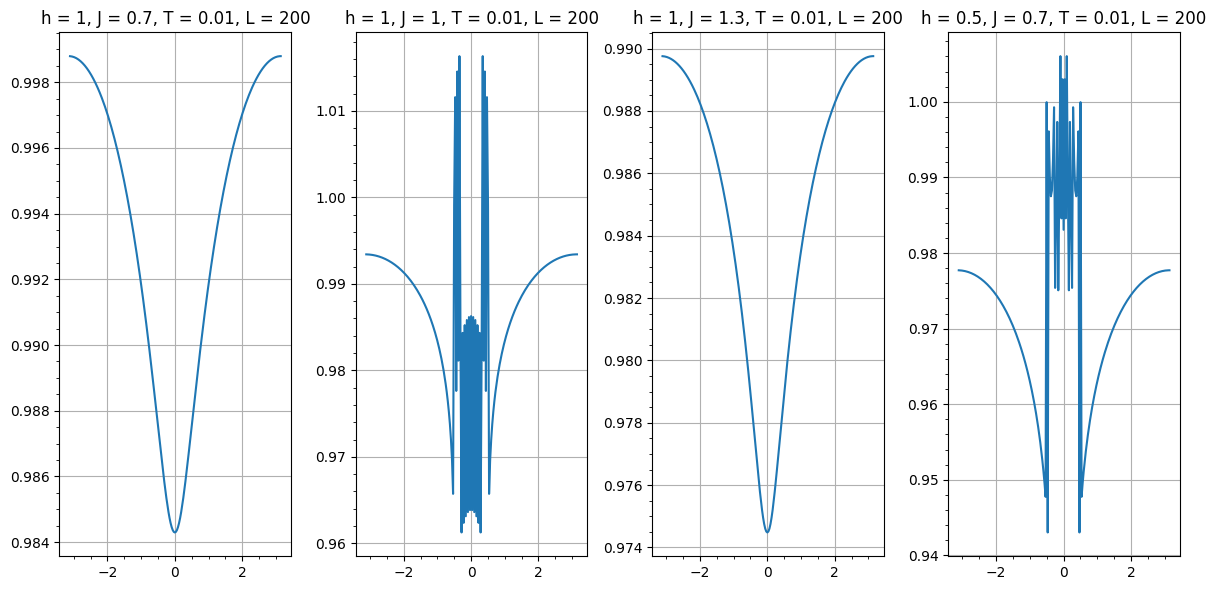

In [196]:
L=200
params = [(L,1,0.7,0.1,0.01),(L,1,1,0.1,0.01),(L,1,1.3,0.1,0.01),(L,0.5,0.7,0.1,0.01)]

fig, axs = plt.subplots(nrows=1,ncols=len(params),figsize=(12,6))
for i in range(len(params)):
    L,h,J,g,T = params[i]
    w_arr , q_space = solve_w_arr(L,h,J,g,T,ax=axs[i],wtol=1.5e-9)
    axs[i].plot(q_space,w_arr)
    axs[i].set_title(f"h = {h}, J = {J}, T = {T}, L = {L}")
    axs[i].minorticks_on()
    axs[i].grid()
fig.tight_layout()

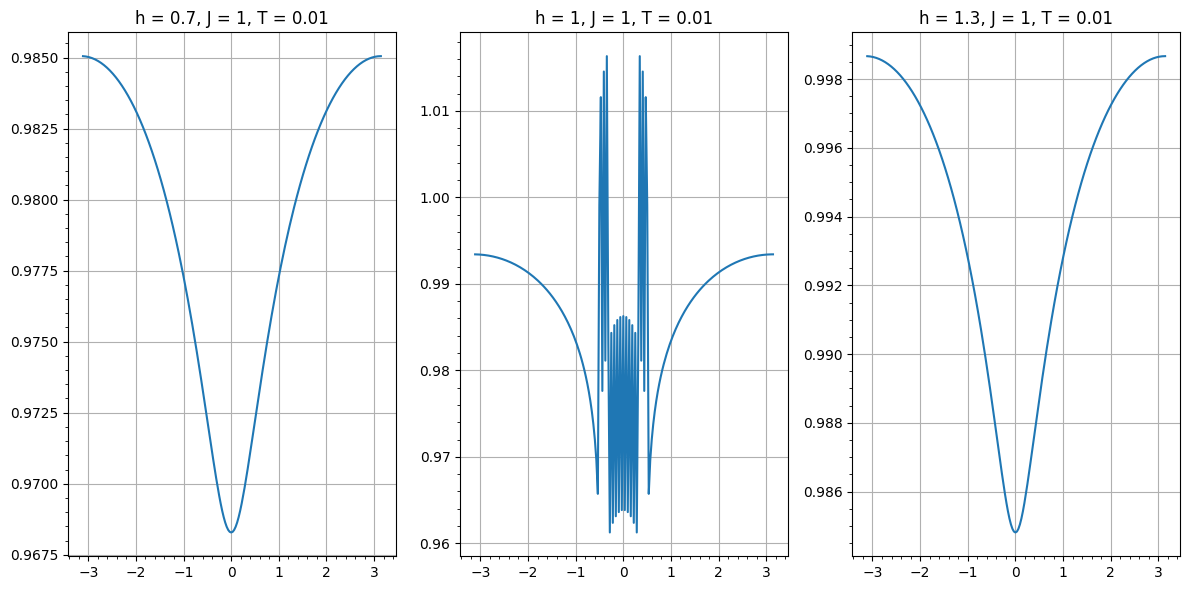

In [65]:
params = [(200,0.7,1,0.1,0.01),(200,1,1,0.1,0.01),(200,1.3,1,0.1,0.01)]

fig, axs = plt.subplots(nrows=1,ncols=len(params),figsize=(12,6))
for i in range(len(params)):
    L,h,J,g,T = params[i]
    w_arr , q_space = solve_w_arr(L,h,J,g,T,ax=axs[i],wtol=1.5e-9)
    axs[i].plot(q_space,w_arr)
    axs[i].set_title(f"h = {h}, J = {J}, T = {T}")
    axs[i].minorticks_on()
    axs[i].grid()
fig.tight_layout()

# Plotting real part of $\Omega_q$

/var/folders/tx/8vpyn5_96mdb4fjlz2yv4khw0000gn/T/ipykernel_885/116065556.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


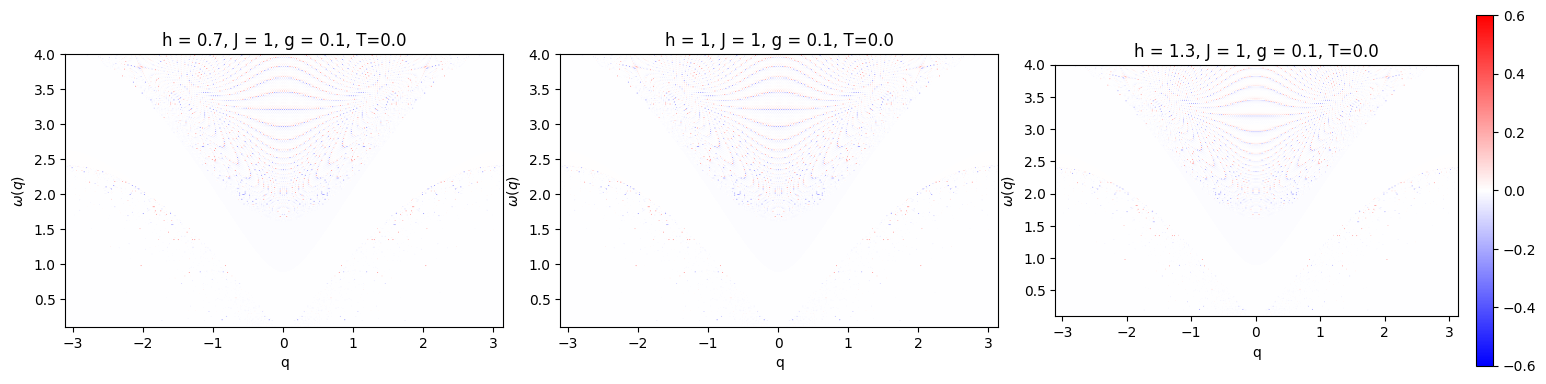

In [145]:
##Plotting the real part of Omega

#Params
params = [(0.7,1,0.1,0.0),(1,1,0.1,0.0),(1.3,1,0.1,0.0)]

fig, axs = plt.subplots(nrows=1,ncols=len(params), figsize = (15,8))

#Grid params
omega_max, omega_min = 4, 0.1
search_gran = 200
L = 200

#Set up meshgrid
omega_space = -np.linspace(-omega_max,-omega_min,num=search_gran)
q_space = [2*n*np.pi/L for n in range(1-int(L/2),int(L/2)+1)]
qq, ww= np.meshgrid(q_space, omega_space)

# Plot the surfaces.
for i in range(len(params)):
    h, J, g, T = params[i]
    Sigma = Omega_real(qq,ww,h,J,g,T,L)
    #im = axs[i].imshow(Sigma , cmap="seismic", interpolation="none", extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-vmax,vmax=vmax)
    im = axs[i].imshow(plot_mat , cmap="bwr", extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-0.6,vmax=0.6, alpha=1)
    axs[i].set_xlabel("q")
    axs[i].set_ylabel("$\omega(q)$",fontsize = 10)
    axs[i].set_title(f"h = {h}, J = {J}, g = {g}, T={T}")
fig.tight_layout()
fig.colorbar(im,fraction=0.04, pad=0.04)
fig.show()

#, interpolation="none"

/var/folders/tx/8vpyn5_96mdb4fjlz2yv4khw0000gn/T/ipykernel_885/1069466736.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


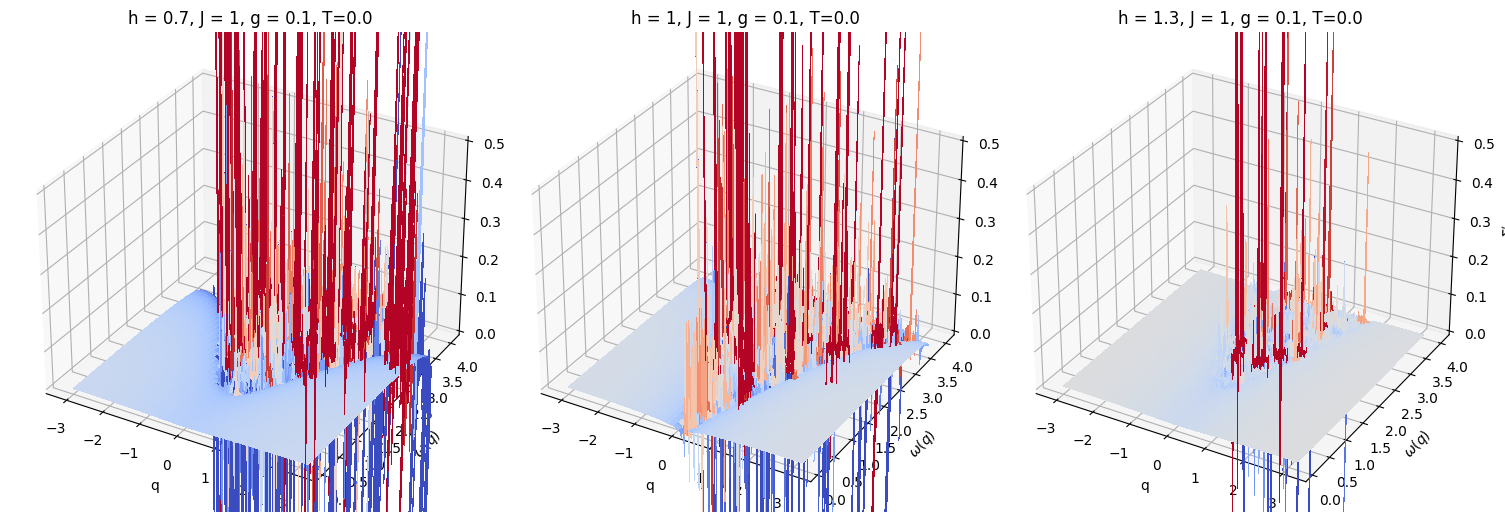

In [144]:
##Plotting the real part of Omega

#Params
params = [(0.7,1,0.1,0.0),(1,1,0.1,0.0),(1.3,1,0.1,0.0)]

fig, axs = plt.subplots(nrows=1,ncols=len(params),subplot_kw={"projection": "3d"},figsize = (15,8))

#Grid params
omega_max, omega_min = 4, 0.1
search_gran = 200
L = 200

#Set up meshgrid
omega_space = -np.linspace(-omega_max,-omega_min,num=search_gran)
q_space = [2*n*np.pi/L for n in range(1-int(L/2),int(L/2)+1)]
qq, ww= np.meshgrid(q_space, omega_space)

# Plot the surfaces.
for i in range(len(params)):
    h, J, g, T = params[i]
    Sigma = Omega_real(qq,ww,h,J,g,T,L)
    surf = axs[i].plot_surface(qq, ww, Sigma, cmap=cm.coolwarm,linewidth=0.1, antialiased=False, vmin=-0.05, vmax=0.05)
    axs[i].set_xlabel("q")
    axs[i].set_ylabel("$\omega(q)$",fontsize = 10)
    axs[i].set_zlabel("$\Sigma'$")
    axs[i].set_title(f"h = {h}, J = {J}, g = {g}, T={T}")
    axs[i].set_zlim(0, 0.5)
fig.tight_layout()
fig.colorbar(im,fraction=0.04, pad=0.04)
fig.show()

/var/folders/tx/8vpyn5_96mdb4fjlz2yv4khw0000gn/T/ipykernel_885/3989340638.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


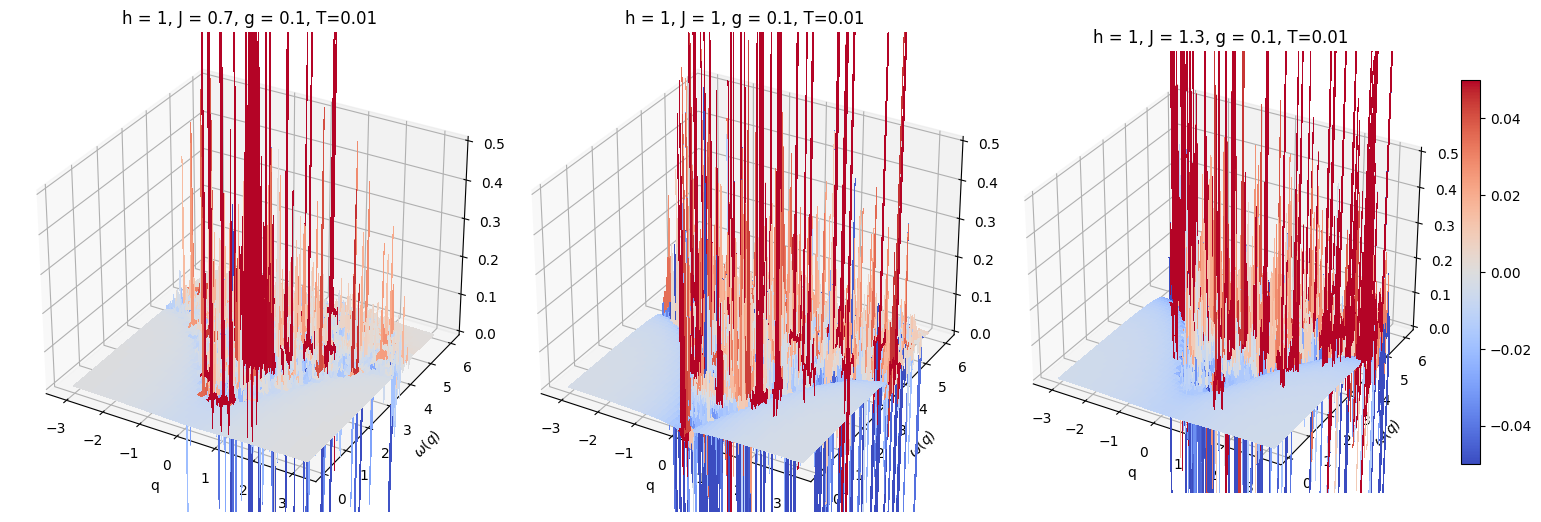

In [138]:
##Plotting the imaginary part of Omega

#Params
params = [(1,0.7,0.1,0.01),(1,1,0.1,0.01),(1,1.3,0.1,0.01)]
fig, axs = plt.subplots(nrows=1,ncols=len(params),subplot_kw={"projection": "3d"},figsize = (15,8))

#Grid params
omega_max, omega_min = 6, 0.1
search_gran = 200
L = 200

#Set up meshgrid
omega_space = -np.linspace(-omega_max,-omega_min,num=search_gran)
q_space = [2*n*np.pi/L for n in range(1-int(L/2),int(L/2)+1)]
qq, ww= np.meshgrid(q_space, omega_space)

# Plot the surfaces.
for i in range(len(params)):
    h, J, g, T = params[i]
    Sigma = Omega_real(qq,ww,h,J,g,T,L)
    surf = axs[i].plot_surface(qq, ww, Sigma, cmap=cm.coolwarm,linewidth=0.1, antialiased=False, vmin=-0.05, vmax=0.05)
    axs[i].set_xlabel("q")
    axs[i].set_ylabel("$\omega(q)$",fontsize = 10)
    axs[i].set_zlabel("$\Sigma'$")
    axs[i].set_title(f"h = {h}, J = {J}, g = {g}, T={T}")
    axs[i].set_zlim(0, 0.5)
fig.tight_layout()
fig.colorbar(surf,fraction=0.04, pad=0.04)
fig.show()

# Imaginary part

In [170]:
##Plotting the imaginary part of Omega

#Grid params
omega_max, omega_min = 1.6, 0.4
search_gran = 50
L = 50

h,J,g = 0.7,1,0.01

#Set up meshgrid
omega_space = -np.linspace(-omega_max,-omega_min,num=search_gran)
q_space = [2*n*np.pi/L for n in range(1-int(L/2),int(L/2)+1)]
qq, ww= np.meshgrid(q_space, omega_space)
im_mat = np.zeros((L,search_gran))
for i in range(len(omega_space)):
    if i%10 == 0:
        print(f"{i/len(omega_space) * 100}% of the way")
    for j in range(len(q_space)):
        w = omega_space[i]
        q = q_space[j]
        impart = impartT0(q,w,g,h,J)[0]
        im_mat[i,j] = impart

0.0% of the way
20.0% of the way
40.0% of the way
60.0% of the way
80.0% of the way


/var/folders/tx/8vpyn5_96mdb4fjlz2yv4khw0000gn/T/ipykernel_885/1547998161.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


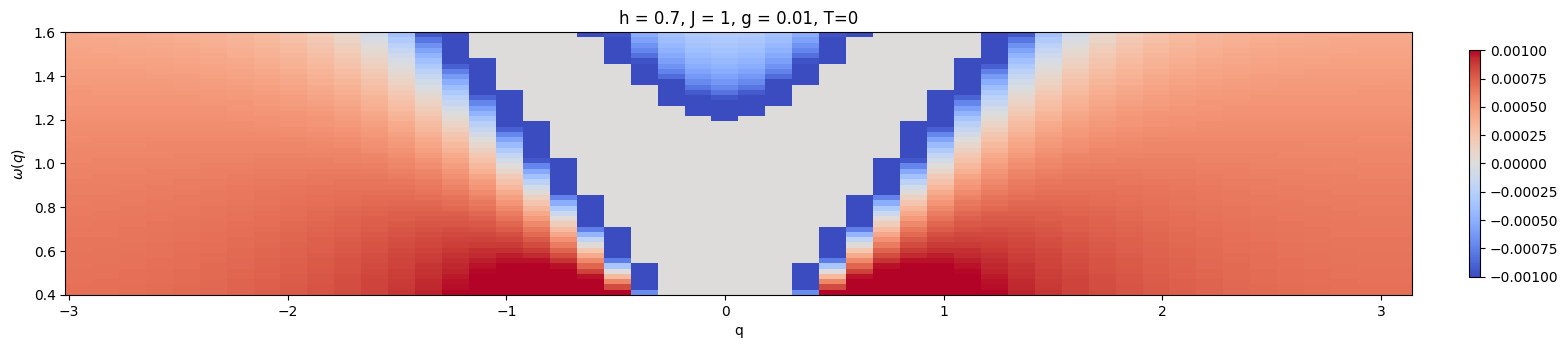

In [177]:
#fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={"projection": "3d"}, figsize = (15,7))
#surf = axs.plot_surface(qq, ww, im_mat, cmap=cm.coolwarm,linewidth=0.1, antialiased=False, vmin=-0.001, vmax=0.001)
fig, axs = plt.subplots(nrows=1,ncols=1,figsize = (15,7))
im = axs.imshow(im_mat, cmap=cm.coolwarm, extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-0.001, vmax=0.001)
axs.set_xlabel("q")
axs.set_ylabel("$\omega(q)$",fontsize = 10)
#axs.set_zlabel("$\Sigma'$")
axs.set_title(f"h = {h}, J = {J}, g = {g}, T={0}")
#axs.set_zlim(-0.01, 0.01)
fig.tight_layout()
#fig.colorbar(surf,fraction=0.04, pad=0.04)
fig.colorbar(im,fraction=0.008, pad=0.04)
fig.show()

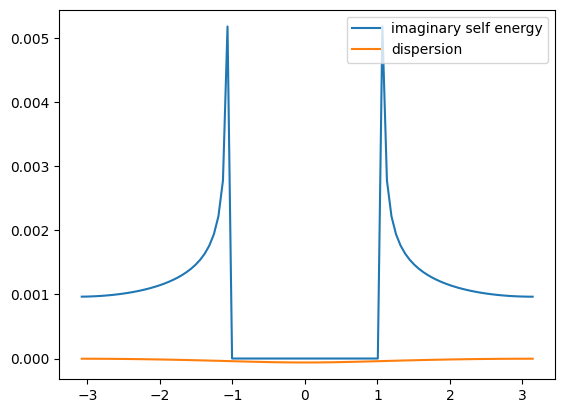

In [187]:
L=100
h=1
J=0.5
g=0.01
T=0

w_arr , q_space = solve_w_arr(L,h,J,g,T,wtol=1.5e-9)

im_space = []
for i in range(L):
    q , w = q_space[i] , w_arr[i]
    im_space.append(impartT0(q,w,g,h,J)[0])

fig, ax = plt.subplots()
ax.plot(q_space,im_space, label="imaginary self energy")
ax.plot(q_space,np.array(w_arr)-1, label="dispersion")
ax.legend()
#ax.plot(q_space,w_arr)

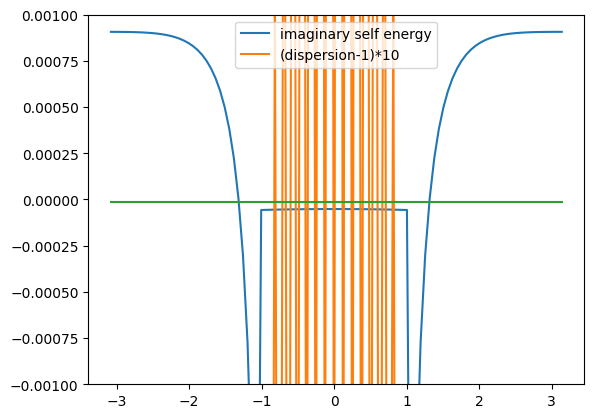

In [195]:
L=100
h=0.5
J=0.5
g=0.01
T=0

w_arr , q_space = solve_w_arr(L,h,J,g,T,wtol=1.5e-9)

im_space = []
for i in range(L):
    q , w = q_space[i] , w_arr[i]
    im_space.append(impartT0(q,w,g,h,J)[0])

fig, ax = plt.subplots()
ax.plot(q_space,im_space, label="imaginary self energy")
ax.plot(q_space,(np.array(w_arr)-1)*10, label="(dispersion-1)*10")
ax.plot(q_space,-np.ones(L)*g**2/32/J**2)
ax.set_ylim(-0.001,0.001)

ax.legend()
#ax.plot(q_space,w_arr)

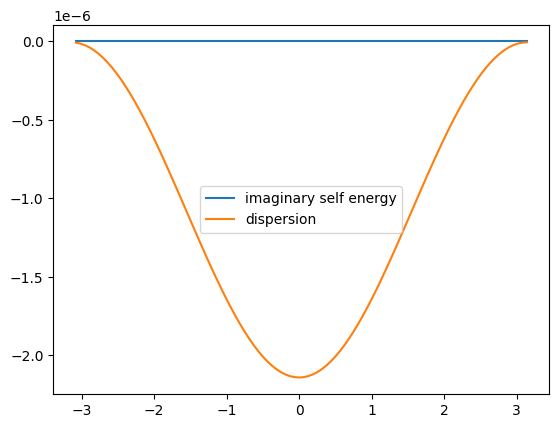

In [186]:
L=100
h=1
J=0.1
g=0.01
T=0

w_arr , q_space = solve_w_arr(L,h,J,g,T,wtol=1.5e-9)

im_space = []
for i in range(L):
    q , w = q_space[i] , w_arr[i]
    im_space.append(impartT0(q,w,g,h,J)[0])

fig, ax = plt.subplots()
ax.plot(q_space,im_space, label="imaginary self energy")
ax.plot(q_space,np.array(w_arr)-1, label="dispersion")
ax.legend()
#ax.plot(q_space,w_arr)

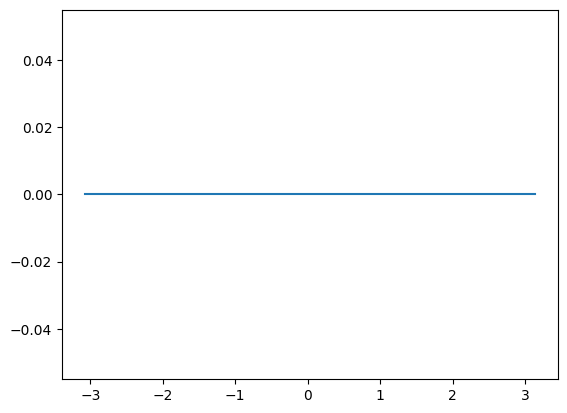

In [72]:
L=100
h=0.1
J=1
g=0.01
T=0

w_arr , q_space = solve_w_arr(L,h,J,g,T,wtol=1.5e-9)

im_space = []
for i in range(L):
    q , w = q_space[i] , w_arr[i]
    im_space.append(impartT0(q,w,g,h,J)[0])

fig, ax = plt.subplots()
ax.plot(q_space,im_space)
#ax.plot(q_space,w_arr)

0.0% of the way
20.0% of the way
40.0% of the way
60.0% of the way
80.0% of the way


/var/folders/tx/8vpyn5_96mdb4fjlz2yv4khw0000gn/T/ipykernel_885/2438000764.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


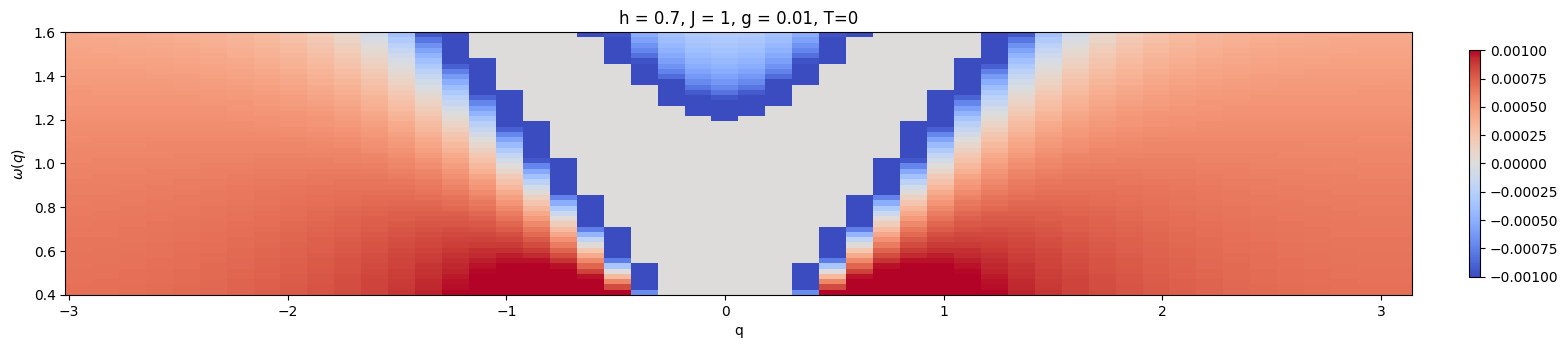

In [178]:
##Plotting the imaginary part of Omega

#Grid params
omega_max, omega_min = 1.6, 0.4
search_gran = 50
L = 50

h,J,g = 0.7,1,0.01

#Set up meshgrid
omega_space = -np.linspace(-omega_max,-omega_min,num=search_gran)
q_space = [2*n*np.pi/L for n in range(1-int(L/2),int(L/2)+1)]
qq, ww= np.meshgrid(q_space, omega_space)
im_mat = np.zeros((L,search_gran))
for i in range(len(omega_space)):
    if i%10 == 0:
        print(f"{i/len(omega_space) * 100}% of the way")
    for j in range(len(q_space)):
        w = omega_space[i]
        q = q_space[j]
        impart = impartT0(q,w,g,h,J)[0]
        im_mat[i,j] = impart
        
#fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={"projection": "3d"}, figsize = (15,7))
#surf = axs.plot_surface(qq, ww, im_mat, cmap=cm.coolwarm,linewidth=0.1, antialiased=False, vmin=-0.001, vmax=0.001)
fig, axs = plt.subplots(nrows=1,ncols=1,figsize = (15,7))
im = axs.imshow(im_mat, cmap=cm.coolwarm, extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-0.001, vmax=0.001)
axs.set_xlabel("q")
axs.set_ylabel("$\omega(q)$",fontsize = 10)
#axs.set_zlabel("$\Sigma'$")
axs.set_title(f"h = {h}, J = {J}, g = {g}, T={0}")
#axs.set_zlim(-0.01, 0.01)
fig.tight_layout()
#fig.colorbar(surf,fraction=0.04, pad=0.04)
fig.colorbar(im,fraction=0.008, pad=0.04)
fig.show()

0.0% of the way
20.0% of the way
40.0% of the way
60.0% of the way
80.0% of the way


/var/folders/tx/8vpyn5_96mdb4fjlz2yv4khw0000gn/T/ipykernel_885/4022869969.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


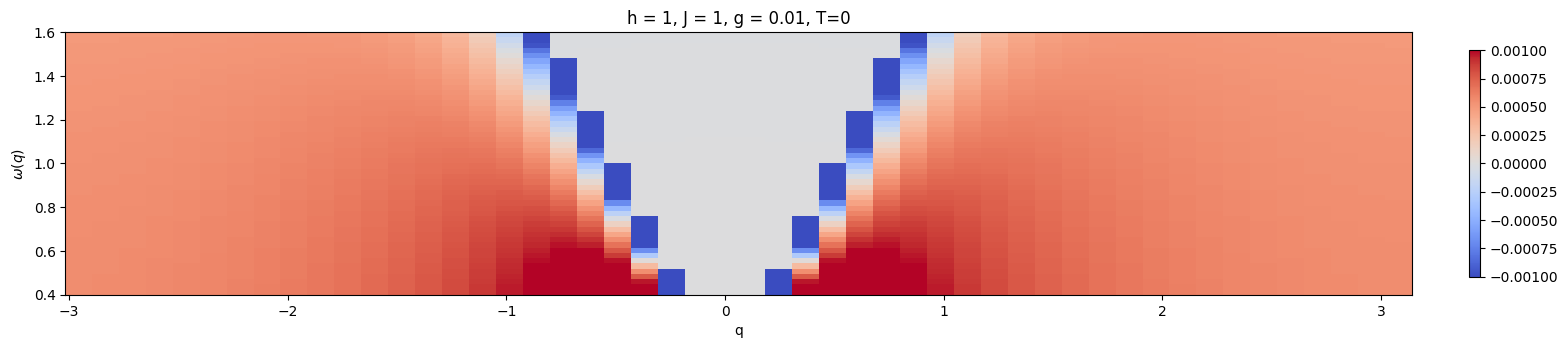

In [179]:
##Plotting the imaginary part of Omega

#Grid params
omega_max, omega_min = 1.6, 0.4
search_gran = 50
L = 50

h,J,g = 1,1,0.01

#Set up meshgrid
omega_space = -np.linspace(-omega_max,-omega_min,num=search_gran)
q_space = [2*n*np.pi/L for n in range(1-int(L/2),int(L/2)+1)]
qq, ww= np.meshgrid(q_space, omega_space)
im_mat = np.zeros((L,search_gran))
for i in range(len(omega_space)):
    if i%10 == 0:
        print(f"{i/len(omega_space) * 100}% of the way")
    for j in range(len(q_space)):
        w = omega_space[i]
        q = q_space[j]
        impart = impartT0(q,w,g,h,J)[0]
        im_mat[i,j] = impart
        
#fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={"projection": "3d"}, figsize = (15,7))
#surf = axs.plot_surface(qq, ww, im_mat, cmap=cm.coolwarm,linewidth=0.1, antialiased=False, vmin=-0.001, vmax=0.001)
fig, axs = plt.subplots(nrows=1,ncols=1,figsize = (15,7))
im = axs.imshow(im_mat, cmap=cm.coolwarm, extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-0.001, vmax=0.001)
axs.set_xlabel("q")
axs.set_ylabel("$\omega(q)$",fontsize = 10)
#axs.set_zlabel("$\Sigma'$")
axs.set_title(f"h = {h}, J = {J}, g = {g}, T={0}")
#axs.set_zlim(-0.01, 0.01)
fig.tight_layout()
#fig.colorbar(surf,fraction=0.04, pad=0.04)
fig.colorbar(im,fraction=0.008, pad=0.04)
fig.show()

0.0% of the way
20.0% of the way
40.0% of the way
60.0% of the way
80.0% of the way


/var/folders/tx/8vpyn5_96mdb4fjlz2yv4khw0000gn/T/ipykernel_885/2496053804.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


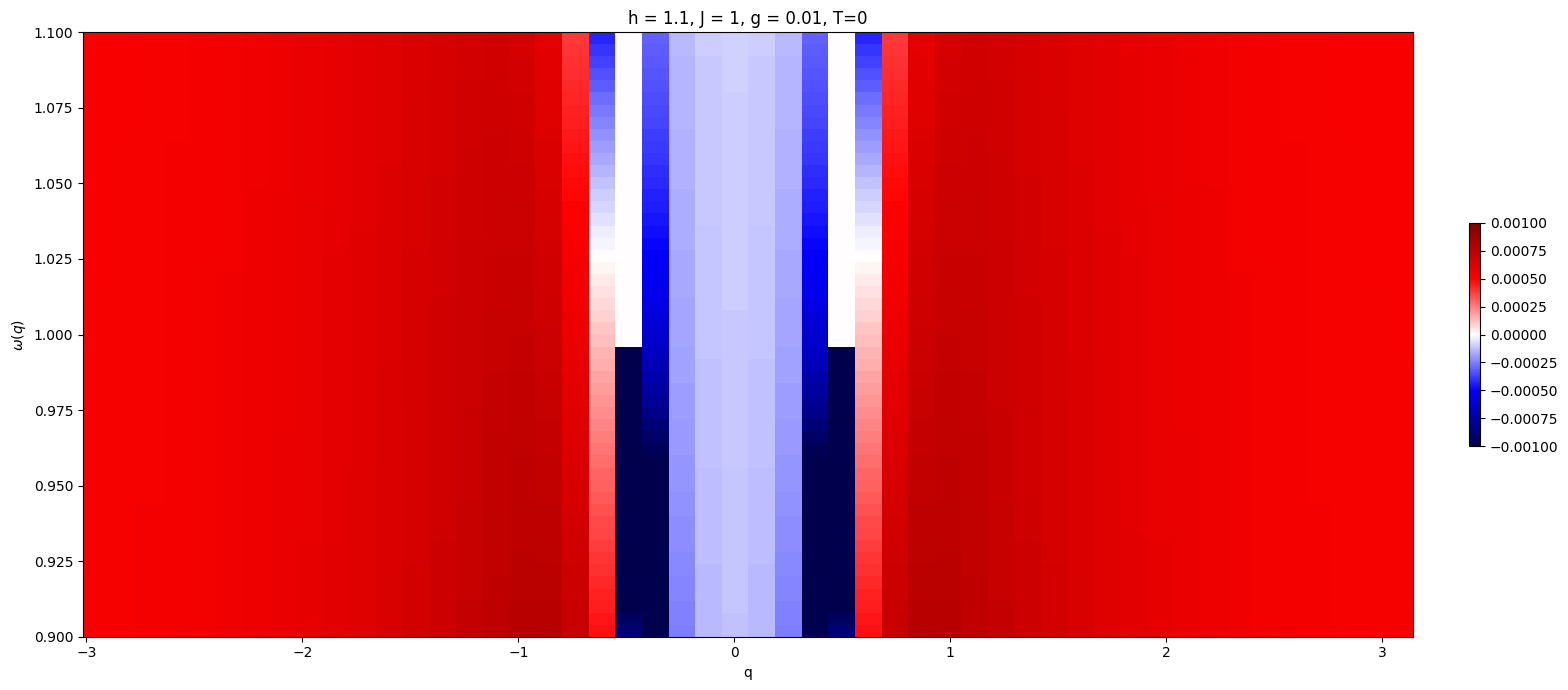

In [251]:
##Plotting the imaginary part of Omega

#Grid params
omega_max, omega_min = 1.1, 0.9
search_gran = 50
L = 50

h,J,g = 1.1,1,0.01

#Set up meshgrid
omega_space = -np.linspace(-omega_max,-omega_min,num=search_gran)
q_space = [2*n*np.pi/L for n in range(1-int(L/2),int(L/2)+1)]
qq, ww= np.meshgrid(q_space, omega_space)
im_mat = np.zeros((L,search_gran))
re_mat = Omega_real(qq,ww,h,J,g,T=0,L=L)
for i in range(len(omega_space)):
    if i%10 == 0:
        print(f"{i/len(omega_space) * 100}% of the way")
    for j in range(len(q_space)):
        w = omega_space[i]
        q = q_space[j]
        impart = impartT0(q,w,g,h,J)[0]
        im_mat[i,j] = impart
        
#fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={"projection": "3d"}, figsize = (15,7))
#surf = axs.plot_surface(qq, ww, im_mat, cmap=cmap=cm.seismic,linewidth=0.1, antialiased=False, vmin=-0.001, vmax=0.001)
fig, axs = plt.subplots(nrows=1,ncols=1,figsize = (15,7))
im = axs.imshow(im_mat, cmap=cm.seismic, extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-0.001, vmax=0.001, aspect="auto")
axs.set_xlabel("q")
axs.set_ylabel("$\omega(q)$",fontsize = 10)
#axs.set_zlabel("$\Sigma'$")
axs.set_title(f"h = {h}, J = {J}, g = {g}, T={0}")
#axs.set_zlim(-0.01, 0.01)
fig.tight_layout()
#fig.colorbar(surf,fraction=0.04, pad=0.04)
fig.colorbar(im,fraction=0.008, pad=0.04)
fig.show()

In [252]:
spectral = spectral_func(qq,ww,re_mat,im_mat,1,1e-15)
print(np.shape(spectral))

(50, 50)


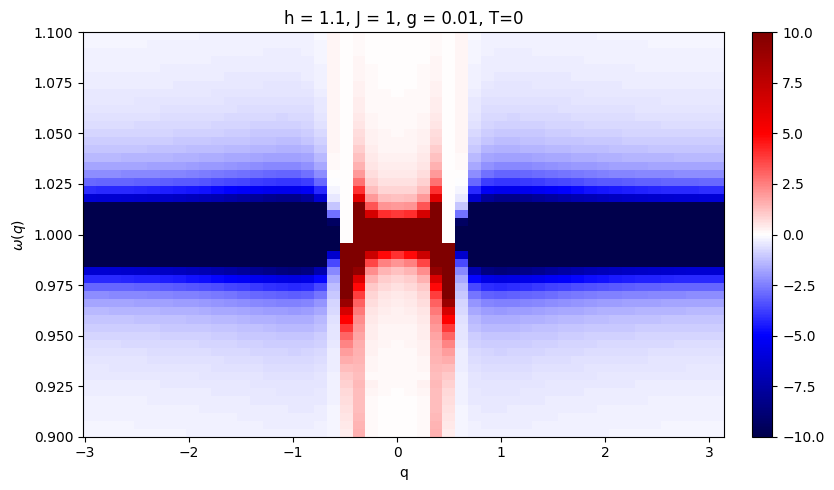

In [253]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
im = axs.imshow(spectral, cmap=cm.seismic, extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-10, vmax=10, aspect="auto")
axs.set_xlabel("q")
axs.set_ylabel("$\omega(q)$",fontsize = 10)
axs.set_title(f"h = {h}, J = {J}, g = {g}, T={0}")
fig.tight_layout()
fig.colorbar(im,fraction=0.04, pad=0.04)

/var/folders/tx/8vpyn5_96mdb4fjlz2yv4khw0000gn/T/ipykernel_885/392784225.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


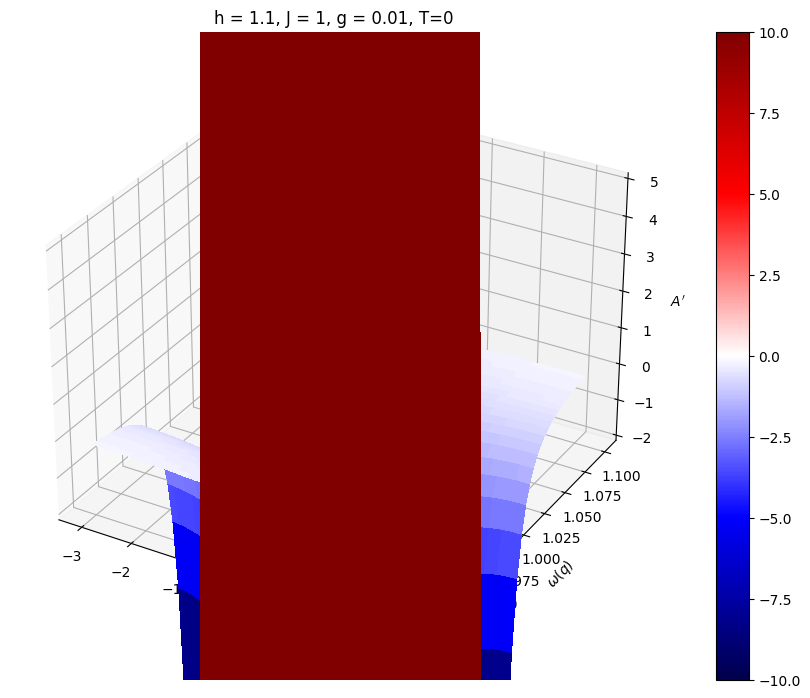

In [254]:
fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={"projection": "3d"}, figsize = (15,7))
surf = axs.plot_surface(qq, ww, spectral, cmap=cm.seismic,linewidth=0.1, antialiased=False, vmin=-10, vmax=10)
axs.set_xlabel("q")
axs.set_ylabel("$\omega(q)$",fontsize = 10)
axs.set_zlabel("$A'$")
axs.set_title(f"h = {h}, J = {J}, g = {g}, T={0}")
axs.set_zlim(-2, 5)
fig.tight_layout()
fig.colorbar(surf,fraction=0.04, pad=0.04)
#fig.colorbar(im,fraction=0.008, pad=0.04)
fig.show()

0.0% of the way
20.0% of the way
40.0% of the way
60.0% of the way
80.0% of the way


/var/folders/tx/8vpyn5_96mdb4fjlz2yv4khw0000gn/T/ipykernel_885/2231295172.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


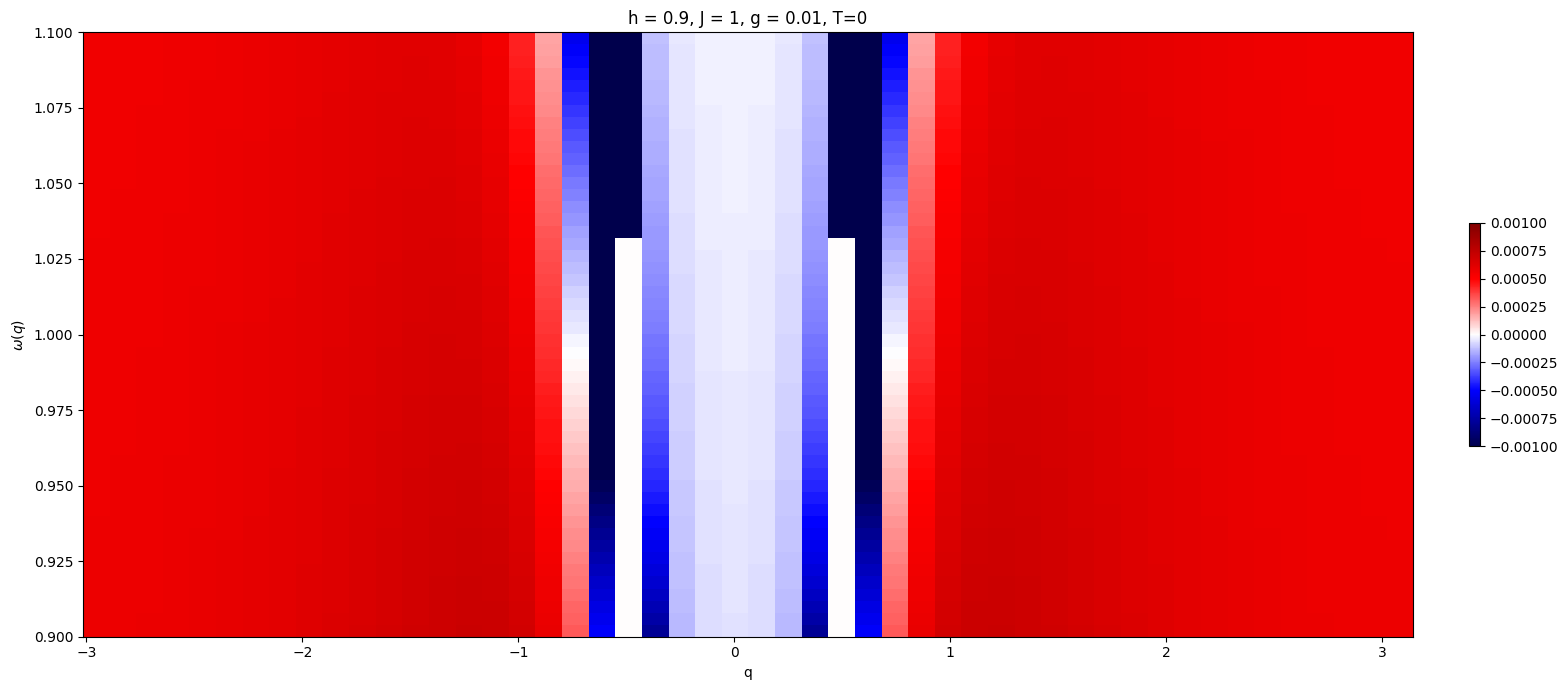

In [255]:
##Plotting the imaginary part of Omega

#Grid params
omega_max, omega_min = 1.1, 0.9
search_gran = 50
L = 50

h,J,g = 0.9,1,0.01

#Set up meshgrid
omega_space = -np.linspace(-omega_max,-omega_min,num=search_gran)
q_space = [2*n*np.pi/L for n in range(1-int(L/2),int(L/2)+1)]
qq, ww= np.meshgrid(q_space, omega_space)
im_mat = np.zeros((L,search_gran))
re_mat = Omega_real(qq,ww,h,J,g,T=0,L=L)
for i in range(len(omega_space)):
    if i%10 == 0:
        print(f"{i/len(omega_space) * 100}% of the way")
    for j in range(len(q_space)):
        w = omega_space[i]
        q = q_space[j]
        impart = impartT0(q,w,g,h,J)[0]
        im_mat[i,j] = impart
        
#fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={"projection": "3d"}, figsize = (15,7))
#surf = axs.plot_surface(qq, ww, im_mat, cmap=cm.seismic,linewidth=0.1, antialiased=False, vmin=-0.001, vmax=0.001)
fig, axs = plt.subplots(nrows=1,ncols=1,figsize = (15,7))
im = axs.imshow(im_mat, cmap=cm.seismic, extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-0.001, vmax=0.001, aspect="auto")
axs.set_xlabel("q")
axs.set_ylabel("$\omega(q)$",fontsize = 10)
#axs.set_zlabel("$\Sigma'$")
axs.set_title(f"h = {h}, J = {J}, g = {g}, T={0}")
#axs.set_zlim(-0.01, 0.01)
fig.tight_layout()
#fig.colorbar(surf,fraction=0.04, pad=0.04)
fig.colorbar(im,fraction=0.008, pad=0.04)
fig.show()

In [256]:
spectral = spectral_func(qq,ww,re_mat,im_mat,1,1e-15)

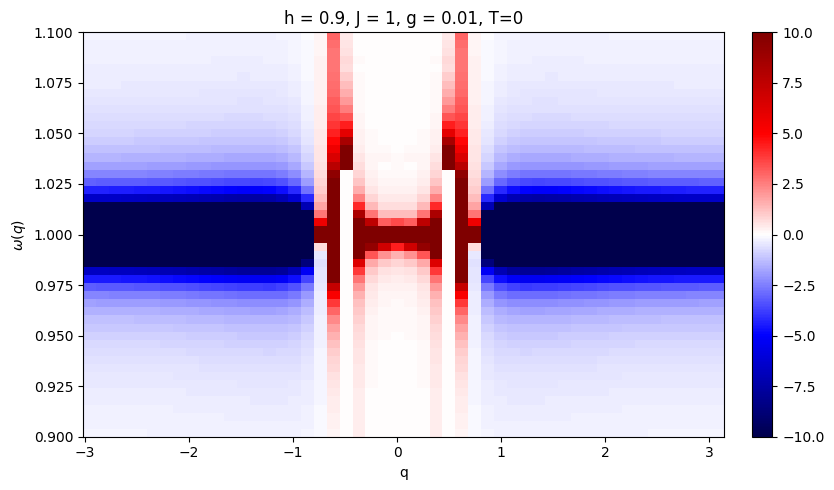

In [257]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
im = axs.imshow(spectral, cmap=cm.seismic, extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-10, vmax=10, aspect="auto")
axs.set_xlabel("q")
axs.set_ylabel("$\omega(q)$",fontsize = 10)
axs.set_title(f"h = {h}, J = {J}, g = {g}, T={0}")
fig.tight_layout()
fig.colorbar(im,fraction=0.04, pad=0.04)

0.0% of the way
20.0% of the way
40.0% of the way
60.0% of the way
80.0% of the way


/var/folders/tx/8vpyn5_96mdb4fjlz2yv4khw0000gn/T/ipykernel_885/1090492178.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


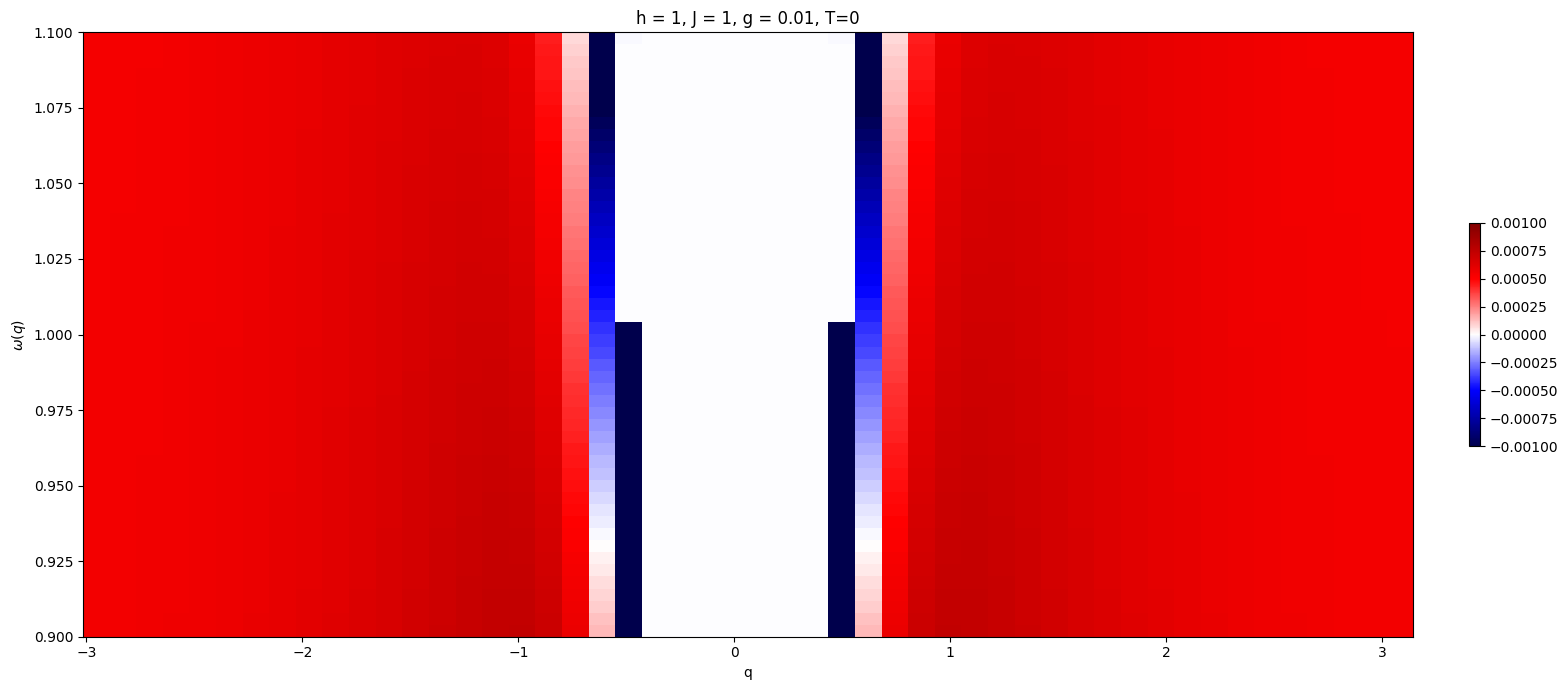

In [244]:
##Plotting the imaginary part of Omega

#Grid params
omega_max, omega_min = 1.1, 0.9
search_gran = 50
L = 50

h,J,g = 1,1,0.01

#Set up meshgrid
omega_space = -np.linspace(-omega_max,-omega_min,num=search_gran)
q_space = [2*n*np.pi/L for n in range(1-int(L/2),int(L/2)+1)]
qq, ww= np.meshgrid(q_space, omega_space)
im_mat = np.zeros((L,search_gran))
re_mat = Omega_real(qq,ww,h,J,g,T=0,L=L)
for i in range(len(omega_space)):
    if i%10 == 0:
        print(f"{i/len(omega_space) * 100}% of the way")
    for j in range(len(q_space)):
        w = omega_space[i]
        q = q_space[j]
        impart = impartT0(q,w,g,h,J)[0]
        im_mat[i,j] = impart
        
#fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={"projection": "3d"}, figsize = (15,7))
#surf = axs.plot_surface(qq, ww, im_mat, cmap=cm.seismic,linewidth=0.1, antialiased=False, vmin=-0.001, vmax=0.001)
fig, axs = plt.subplots(nrows=1,ncols=1,figsize = (15,7))
im = axs.imshow(im_mat, cmap=cm.seismic, extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-0.001, vmax=0.001, aspect="auto")
axs.set_xlabel("q")
axs.set_ylabel("$\omega(q)$",fontsize = 10)
#axs.set_zlabel("$\Sigma'$")
axs.set_title(f"h = {h}, J = {J}, g = {g}, T={0}")
#axs.set_zlim(-0.01, 0.01)
fig.tight_layout()
#fig.colorbar(surf,fraction=0.04, pad=0.04)
fig.colorbar(im,fraction=0.008, pad=0.04)
fig.show()

In [247]:
spectral = spectral_func(qq,ww,re_mat,im_mat,1,1e-15)

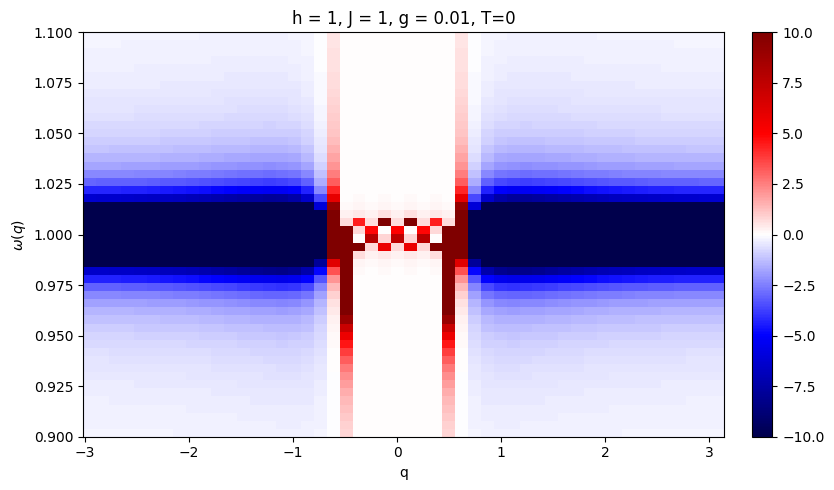

In [248]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
im = axs.imshow(spectral, cmap=cm.seismic, extent=[q_space[0],q_space[-1],omega_space[-1],omega_space[0]], vmin=-10, vmax=10, aspect="auto")
axs.set_xlabel("q")
axs.set_ylabel("$\omega(q)$",fontsize = 10)
axs.set_title(f"h = {h}, J = {J}, g = {g}, T={0}")
fig.tight_layout()
fig.colorbar(im,fraction=0.04, pad=0.04)